This is an exploration of how big a geneset has to be before the average internal connectivity is approximately normally distributed. (Which should happen eventually by the central limit theorem)

## Summary of Conclusions

1. The distribution appears to fit a normal distribution curve for terms in the range of 10-20 genes. However, the standard deviation on large terms is higher than otherwise expected, probably because there is some correlation between the edge weights. So, if gene A and gene B are strongly connected, and gene A and gene C are strongly connected, then B and C are probably strongly connected also. This must become more pronounced at higher term sizes.
2. Another issue is that the high end of the distribution has a lot of outliers that make a normal distribution fit implausible. Discarding outliers seems to alleviate the problems
3. A reasonable solution to these issues is the following: For each size of terms considered, do 1000 random trials to map the distribution. Then record an experimental p-value (limited to p >= 0.001), and fit a normal distribution to a filtered copy of the data to come up with more precise significance estimates.
4. Note that even with outliers removed, there is still a noticable difference between internal connectivity distributions between different testcases of the same type (i.e. random genes vs. random genes)

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from lib.Dab import Dab, get_linear_weights
from lib.Gmt import read_gmt

import matplotlib.pyplot as plt
import scipy.stats

In [2]:
%%time
d = Dab('../data/global.dab')

CPU times: user 5.05 s, sys: 2.3 s, total: 7.36 s
Wall time: 7.35 s


In [3]:
from lib.clustering import *

In [4]:
def internal_connectivity_distribution(dab, set_size, samples=10000):
    results = []
    n = len(dab.genes)
    pairs_per_set = (set_size*(set_size-1))/2
    for i in range(samples):
        set_idxs = np.random.randint(n, size=(set_size))
        total_weight = dab.weights[np.ix_(set_idxs, set_idxs)].sum()
        diag_weight = dab.weights[set_idxs, set_idxs].sum()
        adjusted_weight = (total_weight - diag_weight)/2
        results.append(adjusted_weight/pairs_per_set)
    return results

In [5]:
from scipy.stats import norm
def normality_graph(dab, set_size, samples=10000, mean=None, std=None, results=None):
    """Graphs the distribution of internal connectivity of n-sized gene sets"""
    if results is None:
         results = internal_connectivity_distribution(dab, set_size, samples=samples)
    if mean is None or std is None:
        edges = get_linear_weights(dab)
        mean = edges.mean()
        std = edges.std()
    pairs_per_set = (set_size*(set_size-1))/2
    dev_range = 3*std/(pairs_per_set**0.5)
    plot_range = (mean-dev_range, mean+dev_range)
    _, bins, _ = plt.hist(results, range=plot_range,normed=True, bins=100)
    plt.plot(bins, norm.pdf(bins, loc=mean, scale=std/(pairs_per_set**0.5)))
    meanf, stdf = norm.fit(results)
    print "Fitted mean:", meanf, "Fitted std:", stdf
    plt.plot(bins, norm.pdf(bins, loc=meanf, scale=stdf))
    plt.xlim(plot_range)
    plt.show()

In [6]:
d_edges = get_linear_weights(d)
d_mean = d_edges.mean()
d_std = d_edges.std()

In [7]:
print d_mean, d_std

0.00721141954269 0.0108310630032


In [8]:
%%time
distributions = [0]*151
for i in range(2,151):
    distributions[i] = internal_connectivity_distribution(d, i, samples=1000)

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


In [9]:
means = [0]*151
stds = [0]*151
for i in range(2,151):
    m, s = norm.fit(distributions[i])
    means[i] = m
    stds[i] = s

Fitted mean: 0.00722814524354 Fitted std: 0.00500690587538


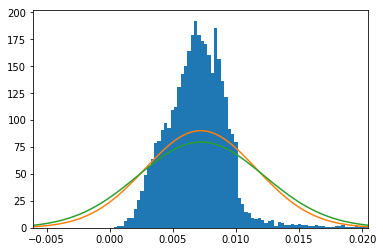

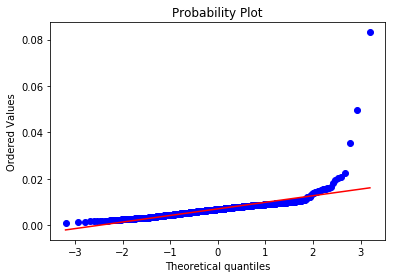

In [10]:
normality_graph(d, 4, mean=d_mean, std=d_std)
scipy.stats.probplot(distributions[4], dist="norm", plot=plt)
plt.show()

Fitted mean: 0.00720788905206 Fitted std: 0.0018964412755


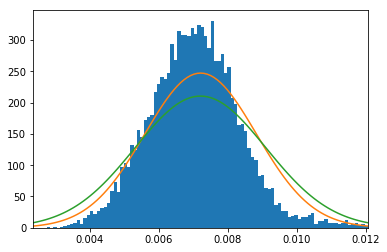

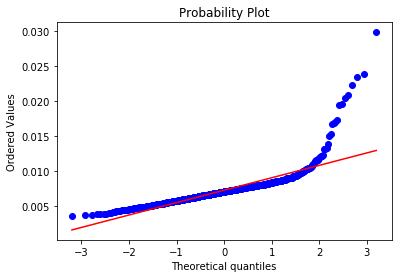

In [11]:
normality_graph(d, 10, mean=d_mean, std=d_std)
scipy.stats.probplot(distributions[10], dist="norm", plot=plt)
plt.show()

Fitted mean: 0.00720474524886 Fitted std: 0.00136966877539


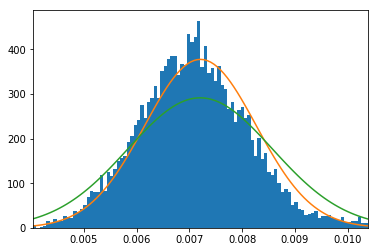

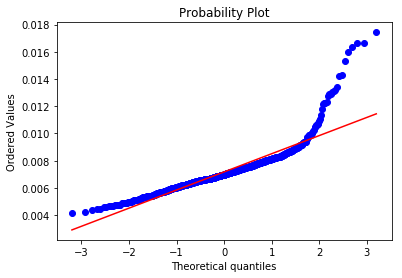

In [12]:
normality_graph(d, 15, samples=10000, mean=d_mean, std=d_std)
scipy.stats.probplot(distributions[15], dist="norm", plot=plt)
plt.show()

Fitted mean: 0.00720802926305 Fitted std: 0.00110293986564


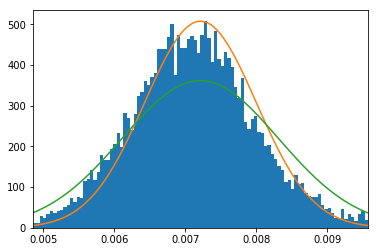

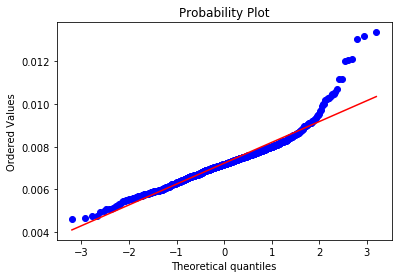

In [13]:
normality_graph(d, 20, mean=d_mean, std=d_std)
scipy.stats.probplot(distributions[20], dist="norm", plot=plt)
plt.show()

Fitted mean: 0.00721228236083 Fitted std: 0.000585727452152


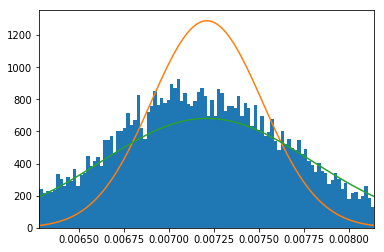

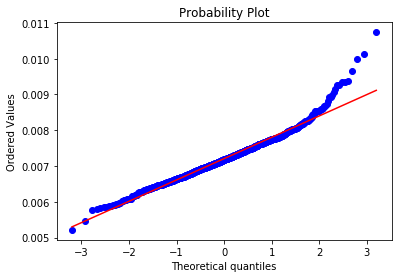

In [14]:
normality_graph(d, 50, mean=d_mean, std=d_std)
scipy.stats.probplot(distributions[50], dist="norm", plot=plt)
plt.show()

Fitted mean: 0.00721158894937 Fitted std: 0.00038529770693


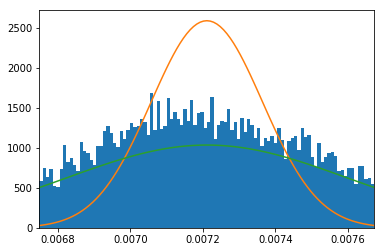

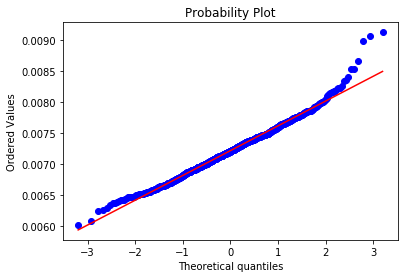

In [15]:
normality_graph(d, 100, mean=d_mean, std=d_std)
scipy.stats.probplot(distributions[100], dist="norm", plot=plt)
plt.show()

The standard deviation does not match our expected rate of increase, probably because the weights within large clusters are correlated with each other

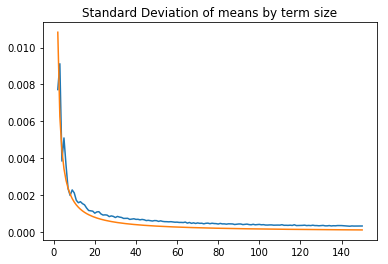

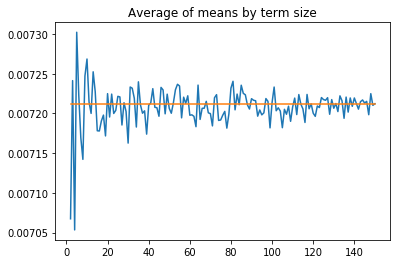

In [16]:
x = range(2,151)
plt.plot(x, stds[2:])
plt.plot(x, [d_std/(n*(n-1)/2)**0.5 for n in x])
plt.title("Standard Deviation of means by term size")
plt.show()
plt.plot(x, means[2:])
plt.plot(x, [d_mean]*149)
plt.title("Average of means by term size")
plt.show()

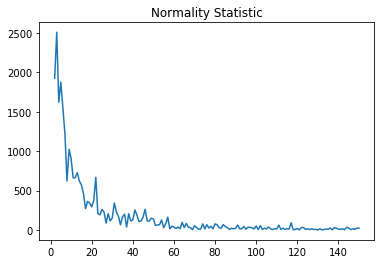

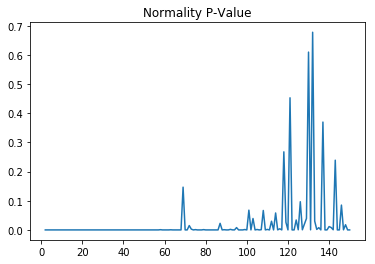

In [17]:
import scipy.stats
norm_statistic = [0]*151
norm_pval = [0]*151
for i in range(2,151):
    norm_statistic[i], norm_pval[i] = scipy.stats.normaltest(distributions[i])

x = range(2,151)
plt.plot(x, norm_statistic[2:])
plt.title("Normality Statistic")
plt.show()
plt.plot(x, norm_pval[2:])
plt.title("Normality P-Value")
plt.show()

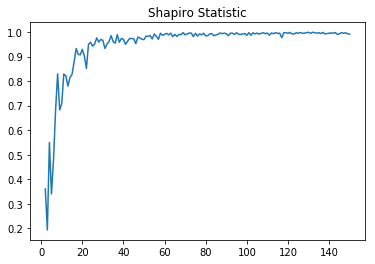

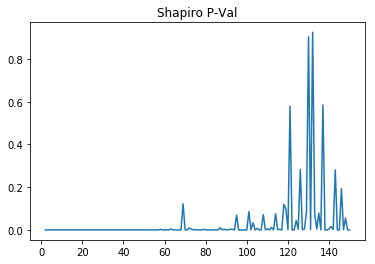

In [18]:
shapiro_stats = [0]*151
shapiro_p = [0]*151
for i in range(2,151):
    shapiro_stats[i], shapiro_p[i] = scipy.stats.shapiro(distributions[i])
plt.plot(x, shapiro_stats[2:])
plt.title("Shapiro Statistic")
plt.show()
plt.plot(x, shapiro_p[2:])
plt.title("Shapiro P-Val")
plt.show()

In [37]:
def discard_outliers(data):
    """Filters a data list by removing any datapoints that are more than 1.5 * the distance
       between 25th and 75th percentiles away from either the 25th or 75th percentile"""
    lo, hi = np.percentile(data, [25, 75])
    lo_cutoff = lo - 1.5*(hi-lo)
    hi_cutoff = hi + 1.5*(hi-lo)
    return [d for d in data if lo_cutoff <= d <= hi_cutoff]


In [20]:
clipped_distributions = map(discard_outliers, distributions[2:])

In [21]:
print sum(len(c) for c in clipped_distributions)/(1.0*len(clipped_distributions))

982.510067114


Term Size of 5


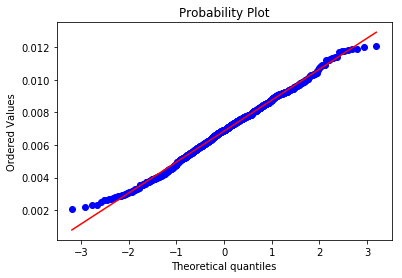

NormaltestResult(statistic=4.3809837013330304, pvalue=0.11186171582499448)
Term Size of 10


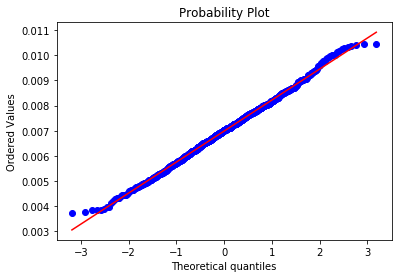

NormaltestResult(statistic=0.58504045980660591, pvalue=0.74638014568497846)
Term Size of 20


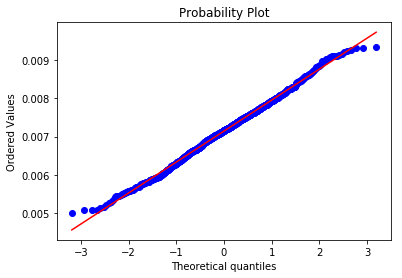

NormaltestResult(statistic=1.3452174368638072, pvalue=0.51037541386861096)
Term Size of 50


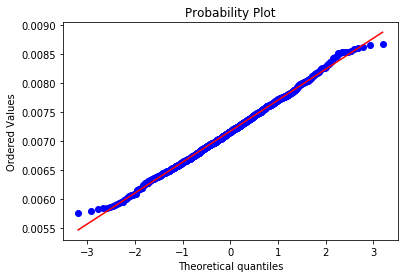

NormaltestResult(statistic=2.5746957736149616, pvalue=0.27600180130814977)
Term Size of 100


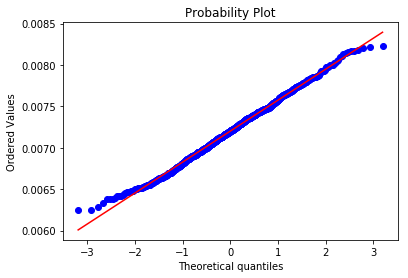

NormaltestResult(statistic=7.3145297326051955, pvalue=0.025802990928752774)
Term Size of 150


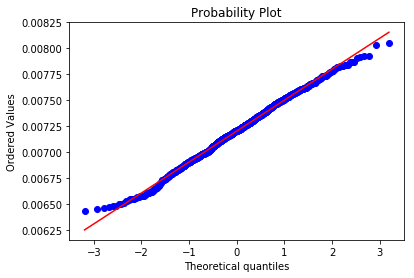

NormaltestResult(statistic=6.4938114502688506, pvalue=0.038894371702594868)


In [22]:
for i in [5,10,20,50,100,150]:
    print "Term Size of", i
    scipy.stats.probplot(clipped_distributions[i-2], dist="norm", plot=plt)
    plt.show()
    print scipy.stats.normaltest(clipped_distributions[i-2])

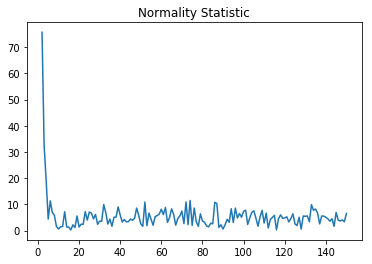

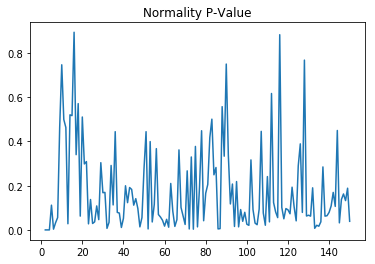

104


In [23]:
norm_statistic = [0]*151
norm_pval = [0]*151
for i in range(2,151):
    norm_statistic[i], norm_pval[i] = scipy.stats.normaltest(clipped_distributions[i-2])

x = range(2,151)
plt.plot(x, norm_statistic[2:])
plt.title("Normality Statistic")
plt.show()
plt.plot(x, norm_pval[2:])
plt.title("Normality P-Value")
plt.show()
print len([p for p in norm_pval if p > 0.05])

In [ ]:
%%time
d_knn = KNN(100).transform(d)

CPU times: user 1min 22s, sys: 1.78 s, total: 1min 24s
Wall time: 1min 24s


In [ ]:
%%time
distributions_knn = [0]*151
for i in range(2,151):
    distributions_knn[i] = internal_connectivity_distribution(d, i, samples=1000)

CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min


Term Size of 5


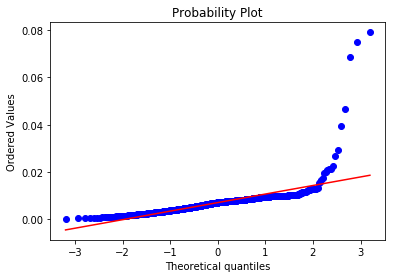

NormaltestResult(statistic=1446.8061750037466, pvalue=0.0)
Term Size of 10


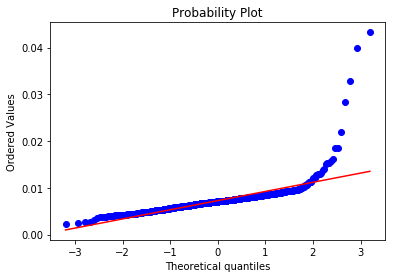

NormaltestResult(statistic=1316.5080338361759, pvalue=1.3301871920194343e-286)
Term Size of 20


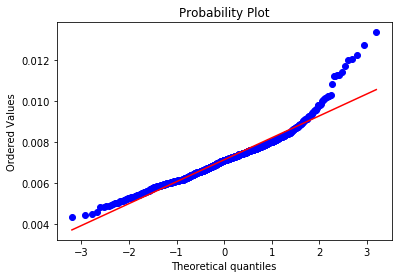

NormaltestResult(statistic=221.10195171534914, pvalue=9.7346696017463675e-49)
Term Size of 50


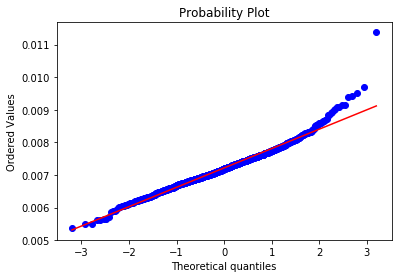

NormaltestResult(statistic=144.58195282618306, pvalue=4.0218683675940471e-32)
Term Size of 100


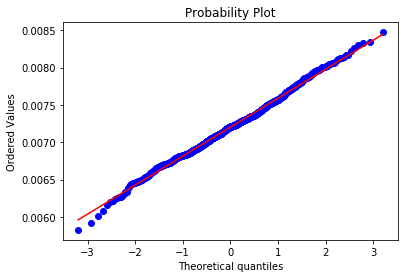

NormaltestResult(statistic=3.4339188176538822, pvalue=0.17961144345051436)
Term Size of 150


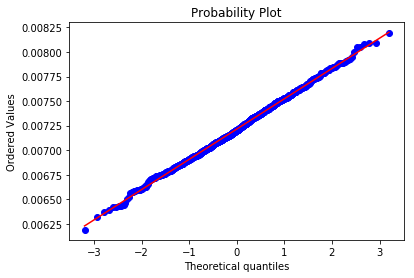

NormaltestResult(statistic=0.88658606775196769, pvalue=0.64191907548991689)


In [ ]:
for i in [5,10,20,50,100,150]:
    print "Term Size of", i
    scipy.stats.probplot(distributions_knn[i-2], dist="norm", plot=plt)
    plt.show()
    print scipy.stats.normaltest(distributions_knn[i-2])

In [ ]:
clipped_knn = map(discard_outliers, distributions_knn[2:])

Term Size of 5


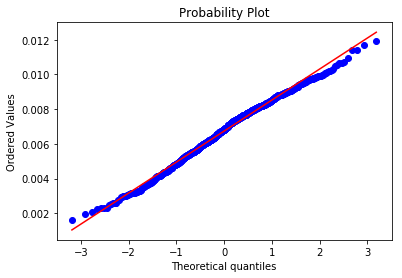

NormaltestResult(statistic=13.9322470718609, pvalue=0.00094330250576471074)
Term Size of 10


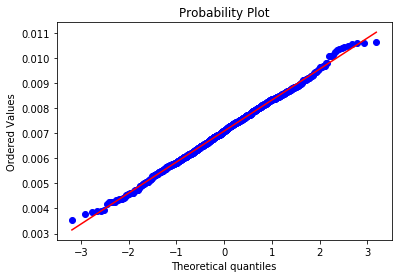

NormaltestResult(statistic=0.28203932945000165, pvalue=0.86847223326210909)
Term Size of 20


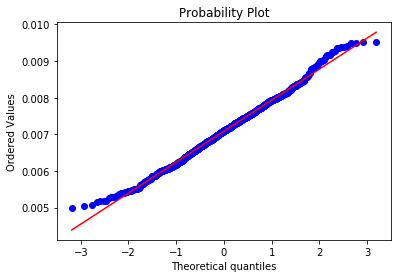

NormaltestResult(statistic=4.1181573114373711, pvalue=0.12757145299399425)
Term Size of 50


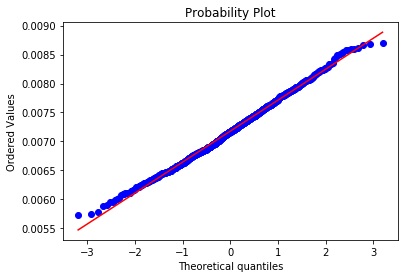

NormaltestResult(statistic=7.3619424944789884, pvalue=0.025198488983379511)
Term Size of 100


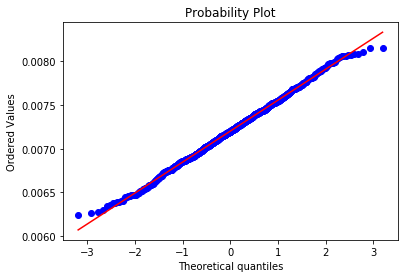

NormaltestResult(statistic=1.6022057272279857, pvalue=0.4488336887127955)
Term Size of 150


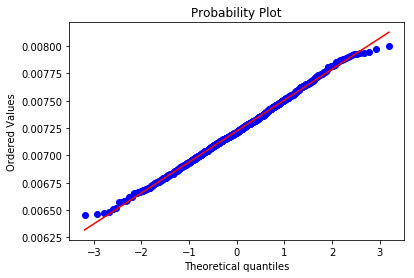

NormaltestResult(statistic=2.9134092136932539, pvalue=0.23300284694415838)


In [ ]:
for i in [5,10,20,50,100,150]:
    print "Term Size of", i
    scipy.stats.probplot(clipped_knn[i-2], dist="norm", plot=plt)
    plt.show()
    print scipy.stats.normaltest(clipped_knn[i-2])

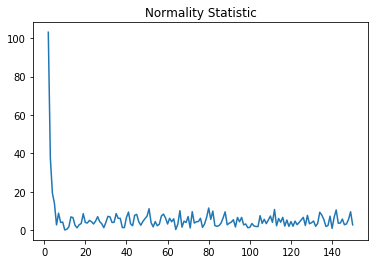

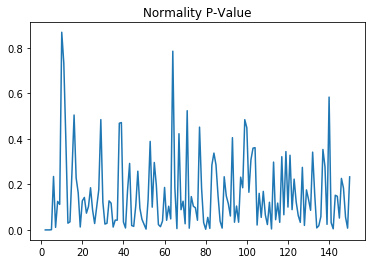

99


In [ ]:
norm_statistic = [0]*151
norm_pval = [0]*151
for i in range(2,151):
    norm_statistic[i], norm_pval[i] = scipy.stats.normaltest(clipped_knn[i-2])

x = range(2,151)
plt.plot(x, norm_statistic[2:])
plt.title("Normality Statistic")
plt.show()
plt.plot(x, norm_pval[2:])
plt.title("Normality P-Value")
plt.show()
print len([p for p in norm_pval if p > 0.05])

In [ ]:
%%time
d_spearman = Spearman().transform(d)

CPU times: user 32min 52s, sys: 16 s, total: 33min 8s
Wall time: 5min 58s


In [ ]:
%%time
distributions_spear = [0]*151
for i in range(2,151):
    distributions_spear[i] = internal_connectivity_distribution(d, i, samples=1000)

CPU times: user 1min 1s, sys: 3 ms, total: 1min 1s
Wall time: 1min 1s


Term Size of 5


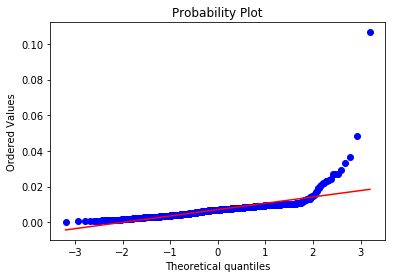

NormaltestResult(statistic=1633.0021724515984, pvalue=0.0)
Term Size of 10


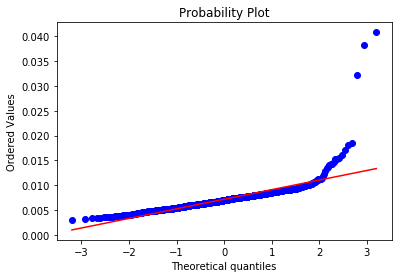

NormaltestResult(statistic=1264.2811806904992, pvalue=2.9162840729624587e-275)
Term Size of 20


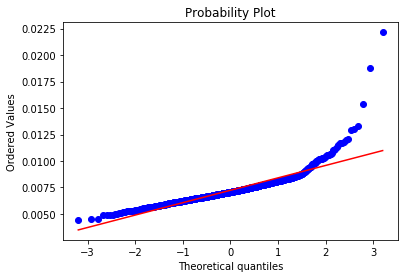

NormaltestResult(statistic=784.57075774430382, pvalue=4.2916532421319808e-171)
Term Size of 50


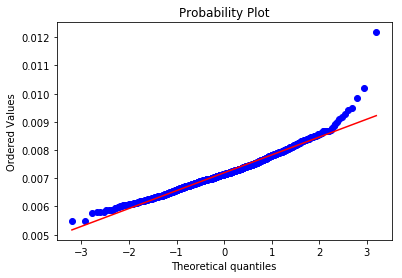

NormaltestResult(statistic=204.39875294657261, pvalue=4.1245326295727772e-45)
Term Size of 100


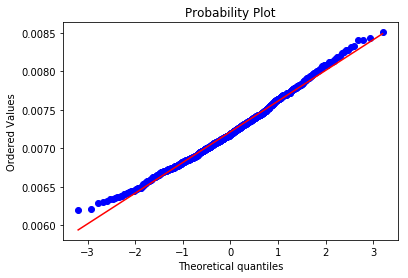

NormaltestResult(statistic=15.254315339725528, pvalue=0.00048704323048286347)
Term Size of 150


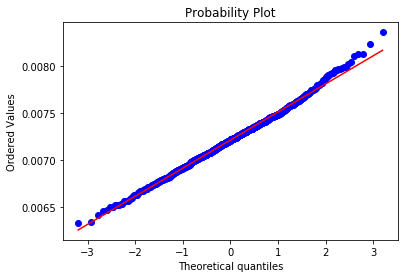

NormaltestResult(statistic=9.075377259002483, pvalue=0.010698105283513981)


In [ ]:
for i in [5,10,20,50,100,150]:
    print "Term Size of", i
    scipy.stats.probplot(distributions_spear[i-2], dist="norm", plot=plt)
    plt.show()
    print scipy.stats.normaltest(distributions_spear[i-2])

In [ ]:
clipped_spear = map(discard_outliers, distributions_spear[2:])

Term Size of 5


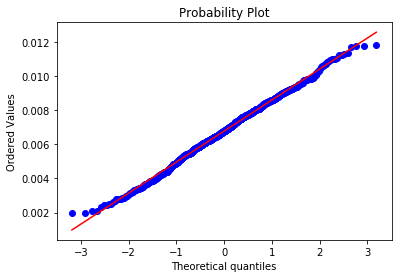

NormaltestResult(statistic=2.47375620265688, pvalue=0.2902890578189149)
Term Size of 10


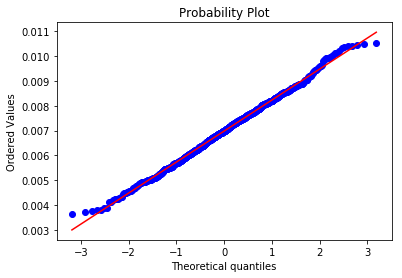

NormaltestResult(statistic=1.1905067530895168, pvalue=0.55142283055424512)
Term Size of 20


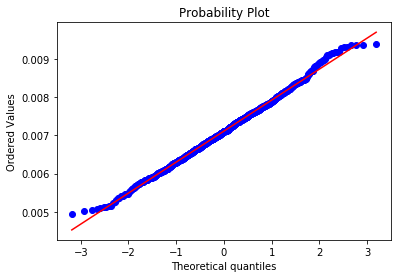

NormaltestResult(statistic=2.6157241058792224, pvalue=0.27039753446989362)
Term Size of 50


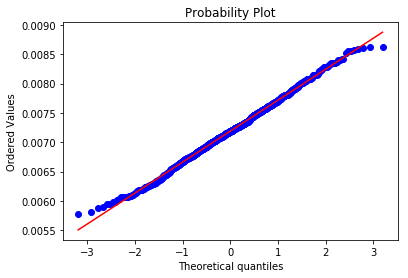

NormaltestResult(statistic=1.6628349245698695, pvalue=0.43543164075186669)
Term Size of 100


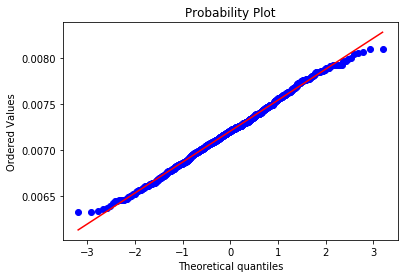

NormaltestResult(statistic=3.2414179175291244, pvalue=0.19775844678882523)
Term Size of 150


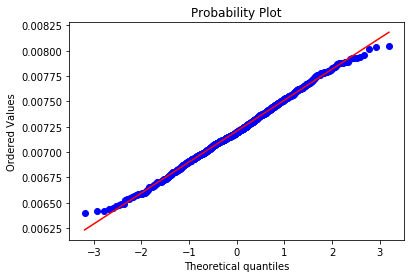

NormaltestResult(statistic=3.128744052039016, pvalue=0.20921935624088678)


In [ ]:
for i in [5,10,20,50,100,150]:
    print "Term Size of", i
    scipy.stats.probplot(clipped_spear[i-2], dist="norm", plot=plt)
    plt.show()
    print scipy.stats.normaltest(clipped_spear[i-2])

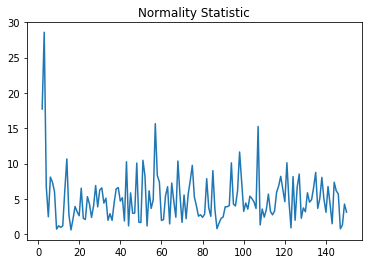

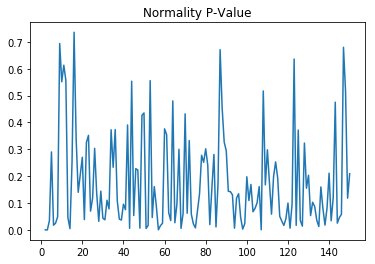

102


In [ ]:
norm_statistic = [0]*151
norm_pval = [0]*151
for i in range(2,151):
    norm_statistic[i], norm_pval[i] = scipy.stats.normaltest(clipped_spear[i-2])

x = range(2,151)
plt.plot(x, norm_statistic[2:])
plt.title("Normality Statistic")
plt.show()
plt.plot(x, norm_pval[2:])
plt.title("Normality P-Value")
plt.show()
print len([p for p in norm_pval if p > 0.05])

## Are distributions comparable across Dabs?
This is a test of whether the distributions are similar across different types of Dabs, in order to get a feel for whether they need to be recalculated on each trieal or not

In [6]:
gen = SavedListGenerator(d).load('genelists/random2600.genelist')
random_dab_2600_a, _ = gen.generateTest()
random_dab_2600_b, _ = gen.generateTest()
gen = SavedListGenerator(d).load('genelists/random100.genelist')
random_dab_100_a, _ = gen.generateTest()
random_dab_100_b, _ = gen.generateTest()
gen = SavedListGenerator(d).load('genelists/gobp.genelist')
gobp_dab_a, _ = gen.generateTest()
gobp_dab_b, _ = gen.generateTest()

In [81]:
def qq_plot(d1, d2, term_size, clip=True, samples=10000, xlab="", ylab=""):
    x = internal_connectivity_distribution(d1, term_size, samples=samples)
    y = internal_connectivity_distribution(d2, term_size, samples=samples)
    if clip:
        x = discard_outliers(x)
        y = discard_outliers(y)
        x = x[:min(len(x),len(y))]
        y = y[:min(len(x),len(y))]
    limits = (min(x+y), max(x+y))
    plt.plot(limits, limits, color='r')
    plt.plot(sorted(x),sorted(y))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

Comparing 10 and 50-gene sets from random 2600 gene dabs

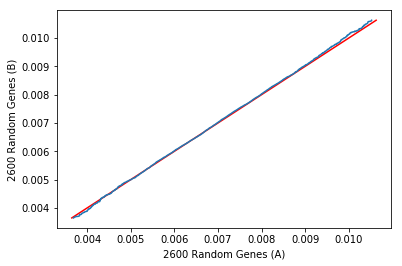

In [82]:
qq_plot(random_dab_2600_a, random_dab_2600_b, 10, xlab="2600 Random Genes (A)", ylab="2600 Random Genes (B)")

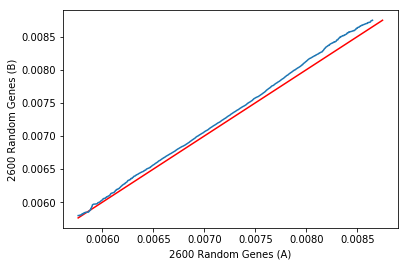

In [83]:
qq_plot(random_dab_2600_a, random_dab_2600_b, 50, xlab="2600 Random Genes (A)", ylab="2600 Random Genes (B)")

Comparing 10 and 20-gene sets from random 100 gene dabs

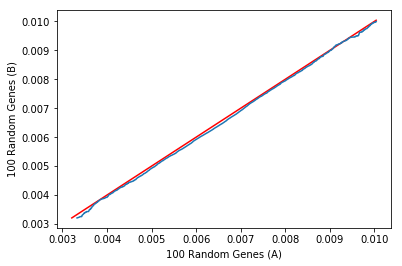

In [68]:
qq_plot(random_dab_100_a, random_dab_100_b, 10, xlab="100 Random Genes (A)", ylab="100 Random Genes (B)")

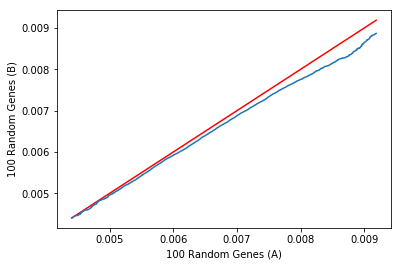

In [69]:
qq_plot(random_dab_100_a, random_dab_100_b, 20, xlab="100 Random Genes (A)", ylab="100 Random Genes (B)")

Comparing 10 and 50-gene sets from biological process 2600-gene dabs

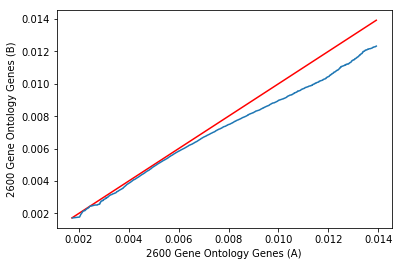

In [70]:
qq_plot(gobp_dab_a, gobp_dab_b, 10, xlab="2600 Gene Ontology Genes (A)",
                                    ylab="2600 Gene Ontology Genes (B)")

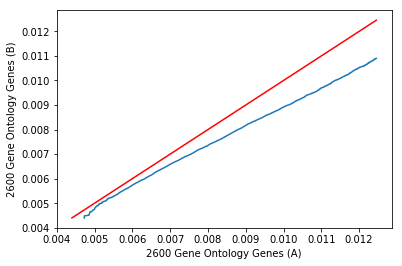

In [71]:
qq_plot(gobp_dab_a, gobp_dab_b, 50, xlab="2600 Gene Ontology Genes (A)",
                                    ylab="2600 Gene Ontology Genes (B)")

Comparing 10 and 50-gene sets from a random 2600 gene dab to a GO BP dab

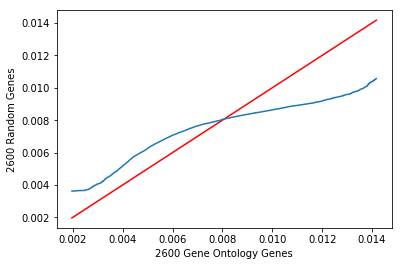

In [72]:
qq_plot(gobp_dab_a, random_dab_2600_a, 10, xlab="2600 Gene Ontology Genes",
                                           ylab="2600 Random Genes")

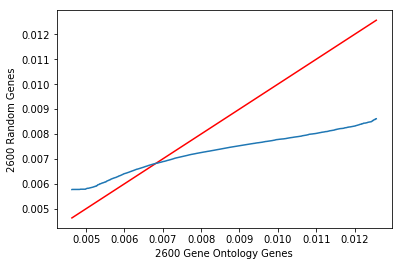

In [73]:
qq_plot(gobp_dab_a, random_dab_2600_a, 50, xlab="2600 Gene Ontology Genes",
                                           ylab="2600 Random Genes")

Comparing 10 and 20-gene sets from a 100-gene Dab and a 2600-gene Dab

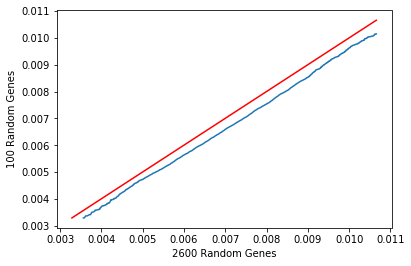

In [74]:
qq_plot(random_dab_2600_a, random_dab_100_a, 10, xlab="2600 Random Genes",
                                                 ylab="100 Random Genes")

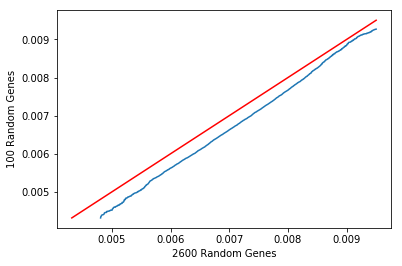

In [75]:
qq_plot(random_dab_2600_a, random_dab_100_a, 20, xlab="2600 Random Genes",
                                                 ylab="100 Random Genes")